## Getting Started with TipTop - Step-by-Step Tutorial

*Last update: September, 2025*

This notebook walks you through running a TIPTOP simulation and visualizing PSFs (AO, diffraction limited, seeing limited).

> **Goals**
> 1. Verify installation and configure input/output paths
> 2. Run a simulation with `overallSimulation`
> 3. Open the output FITS file and extract PSFs and metadata

## Requirements

- Python 3.11+ recommended
- Packages: `tiptop v.1.3.29`, `astropy`, `matplotlib`, `numpy`
- A valid TIPTOP `.ini` parameter file (e.g. *ERIS_SCAO_NGS.ini*)

## Running TIPTOP on CPU in Google Colab 

For this tutorial, a GPU is **not required**. Colab GPUs depend on specific CUDA drivers, and if the preinstalled CuPy doesn’t match the active CUDA/driver, imports can fail.  

This is the most reliable setup for a quick “getting started”; it’s fast enough for the examples here.  
If you later want acceleration, you can switch to a GPU runtime and install the matching CuPy wheel.

## 0) CPU environment setup

In [ ]:
# Detect Colab and install packages in the right interpreter
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# Always use %pip in notebooks (installs into the active kernel)
# CPU mode: avoid CUDA/CuPy issues by removing CuPy and installing CPU deps
%pip -q uninstall -y cupy cupy-cuda12x cupy-cuda11x || true
%pip -q install --upgrade pip
%pip -q install astro-tiptop astropy matplotlib numpy

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 

### Verify TipTop

In [ ]:
import tiptop
print("TIPTOP version:", getattr(tiptop, "__version__", "unknown"))

## 1) Imports

In [1]:
from tiptop.tiptop import *
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

Cupy import successfull. Installed version is: 13.4.1
Cupy import successfull. Installed version is: 13.4.1
Cupy import successfull. Installed version is: 13.4.1


## 2) (Optional) Set working directory to TipTop root

Useful to direclty access the `.ini` files in `tiptop/perfTest`.

In [2]:
#%% 💡Set working directory to TIPTOP root (optional)
import tiptop 
import os
tiptop_path = os.path.dirname(os.path.dirname(tiptop.__file__))
print(f"TIPTOP package directory: {tiptop_path}")
# Uncomment to set as working directory:
os.chdir(tiptop_path)
print('CWD =', os.getcwd())


TIPTOP package directory: C:\Users\lmazzolo\Documents\PRO\astro-tiptop\TIPTOP
CWD = C:\Users\lmazzolo\Documents\PRO\astro-tiptop\TIPTOP


## 2) Define paths and filenames

- `path_in` : folder containing your `.ini` parameter file
- `path_out` : output folder (must exist or be creatable)
- `file_in` : base name (without extension) of the `.ini` file
- `file_out` : prefix for output files

Click [here](https://astro-tiptop-services.github.io/astro-tiptop-services/docs/orion/aoinstruments) to see `.ini` configuration files tailored for various instruments: ERIS, HARMONI, MAVIS, MORFEO, MUSE, SOUL, SPHERE.

In [3]:

# %% Path configuration — adapt to your setup
path_in = "tiptop/perfTest/"  # relative to TIPTOP_ROOT if you used os.chdir(tiptop_path)
path_out = "./TIPTOP_OUT/" # use an absolute path if you want outputs to be saved outside the TIPTOP root
file_in = "ERIS"     # without .ini extension
file_out = "ERIS"    # output prefix

# Create output folder if needed
os.makedirs(path_out, exist_ok=True)

print("path_in :", path_in)
print("path_out:", path_out)
print("file_in :", file_in)
print("file_out:", file_out)


path_in : tiptop/perfTest/
path_out: ./TIPTOP_OUT/
file_in : ERIS
file_out: ERIS


## (Optional) List available `.ini`files

In [4]:
from pathlib import Path
p = Path(path_in)
if not p.exists():
    print(f"[WARN] The folder {p} does not exist in your current working directory.")
else:
    print('INI files under', p.resolve())
    for ini in sorted(p.glob('*.ini')):
        print(' -', ini.name)

INI files under C:\Users\lmazzolo\Documents\PRO\astro-tiptop\TIPTOP\tiptop\perfTest
 - dummy.ini
 - ERIS.ini
 - ERIS_LGS.ini
 - HARMONI_SCAO.ini
 - HarmoniLTAO_1.ini
 - HarmoniLTAO_2.ini
 - HarmoniLTAO_3.ini
 - MAVIS.ini
 - MAVIStest.ini
 - MICADO_SCAO.ini
 - MORFEO.ini
 - SOUL.ini
 - SPHERE.ini


## 4) Run TIPTOP simulation

`tiptop.overallSimulation` runs a complete TipTop simulation based on an input parameter file. The function accepts several optional arguments to enable or disable specific features and select desired outputs. 
Click [here](https://astro-tiptop-services.github.io/astro-tiptop-services/docs/orion/howtosetuplaunchfile#overallSimulation) to access to the overallSimulation function documentation.

In [5]:
overallSimulation(path_in, file_in, path_out, file_out)
print("✅ Simulation complete")

✅ Simulation complete


## 5) Open the output FITS and extract data

We extract:
- **AO-corrected PSF** (HDU 1)
- **Seeing-limited PSF** (HDU 2)
- **Diffraction-limited PSF** (HDU 3)
- **Radial profiles** (HDU 4 or 5 depending on save options)
- Useful metadata from the FITS header (wavelength, pixel scale, Strehl, FWHM)

Click [here](https://astro-tiptop-services.github.io/astro-tiptop-services/docs/orion/howtosetuplaunchfile#simulation_output) to the simulation output documentation.


In [6]:

# %% Open FITS file
fits_path = os.path.join(path_out, file_out + ".fits")
print("Reading:", fits_path)

with fits.open(fits_path) as hdul:
    hdul.info()

    psf_ao   = hdul[1].data[0, ...]  # AO-corrected
    psf_turb = hdul[2].data          # seeing-limited
    psf_dl   = hdul[3].data          # diffraction-limited

    # Profiles (HDU 4 or 5 depending on CONTENT)
    header4 = hdul[4].header
    if header4.get('CONTENT') == 'Final PSFs profiles':
        profiles = hdul[4].data
    else:
        profiles = hdul[5].data

    # Metadata
    psf_header = hdul[1].header
    wvl = float(psf_header.get("WL_NM"))        # wavelength (nm)
    pix_mas = float(psf_header.get("PIX_MAS"))  # pixel scale (mas)

    # ✅ corrected from original script:
    sr_key   = f"SR{0:04d}"
    fwhm_key = f"FWHM{0:04d}"
    sr   = psf_header.get(sr_key)    # Strehl ratio
    fwhm = psf_header.get(fwhm_key)  # FWHM (mas)

print("Pixel scale [mas]:", pix_mas)
print("Strehl Ratio:", sr)
print("FWHM [mas]:", fwhm)
print("Wvl [nm]:", wvl)


Reading: ./TIPTOP_OUT/ERIS.fits
Filename: ./TIPTOP_OUT/ERIS.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   ()      
  1                1 ImageHDU        21   (256, 256, 1)   float64   
  2                1 ImageHDU        10   (256, 256)   float64   
  3                1 ImageHDU        10   (256, 256)   float64   
  4                1 ImageHDU        11   (128, 1, 2)   float64   
Pixel scale [mas]: 14.0
Strehl Ratio: 0.89112
FWHM [mas]: 44.116
Wvl [nm]: 1650.0


## 6) Normalize PSFs and build axis in arcseconds

In [7]:
# %% Normalize
psf_ao   = psf_ao / np.sum(psf_ao)
psf_dl   = psf_dl / np.sum(psf_dl)
psf_turb = psf_turb / np.sum(psf_turb)

# Axis in arcsec
nx = psf_ao.shape[0]
axis = np.linspace(-nx//2, nx//2, nx) * pix_mas * 1e-3  # mas -> arcsec

## 7) Visualize PSFs (log scale)

We adjust the dynamic range to display down to 10⁻⁶ of the maximum.


In [9]:
# %% Plot PSFs
def plot_psf(psf, title, position):
    plt.subplot(1, 3, position)
    im = plt.imshow(psf, norm=norm, cmap='Spectral_r',
                    extent=[axis[0], axis[-1], axis[0], axis[-1]])
    plt.title(title, pad=10)
    plt.xlabel('[arcsec]')
    if position == 1:
        plt.ylabel('[arcsec]')
    else:
        plt.ylabel('')
    plt.colorbar(im, fraction=0.046)

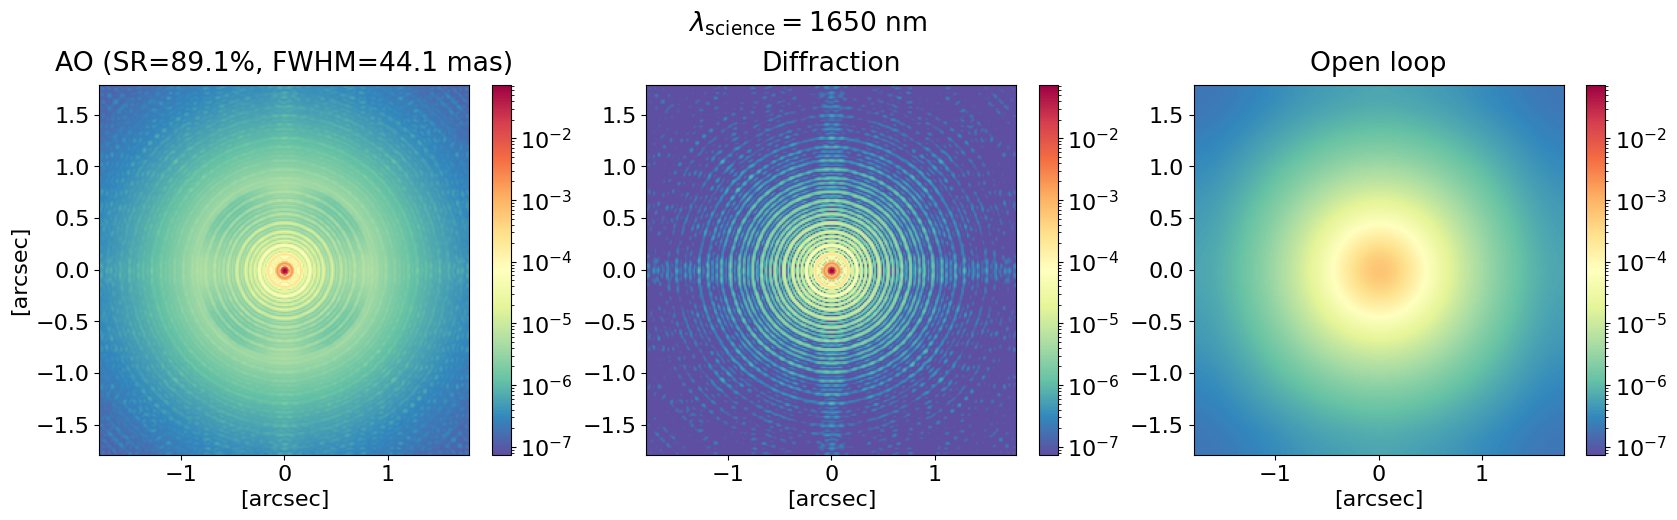

In [10]:
psf_max = psf_ao.max()
vmax = psf_max
vmin = psf_max * 1e-6
norm = LogNorm(vmin=vmin, vmax=vmax)

plt.figure(1, figsize=(20, 5))
plt.suptitle(rf'$\lambda_{{\mathrm{{science}}}} = {int(wvl)}$ nm', y=1)
plt.subplots_adjust(top=0.85)
plot_psf(psf_ao,  f'AO (SR={sr*100:.1f}%, FWHM={fwhm:.1f} mas)', 1)
plot_psf(psf_dl,  'Diffraction', 2)
plot_psf(psf_turb,'Open loop', 3)
plt.show()


## 8) Plot radial profile (AO PSF)

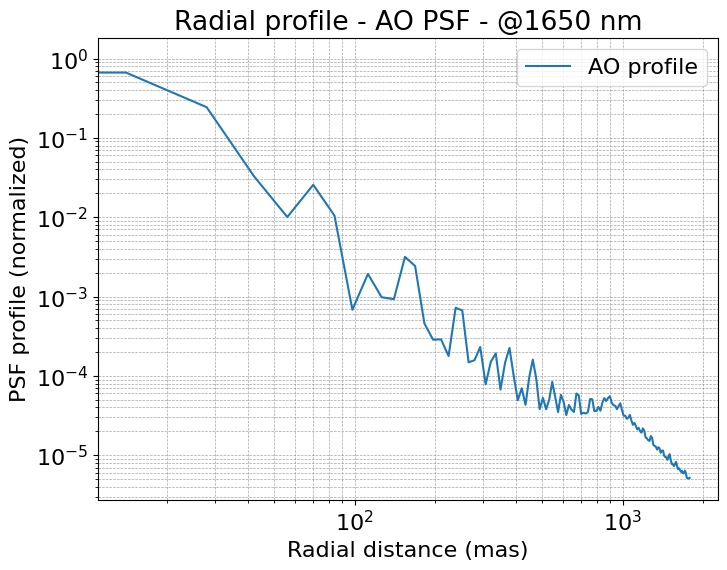

In [11]:
# %% Radial profile
radii = profiles[0, 0, :]
p_norm = profiles[1, 0, :] / np.max(profiles[1, 0, :])

plt.figure(figsize=(8, 6))
plt.plot(radii, p_norm, label='AO profile')
plt.xlabel('Radial distance (mas)')
plt.ylabel('PSF profile (normalized)')
plt.xscale("log")
plt.yscale("log")
plt.title(f'Radial profile - AO PSF - @{int(wvl)} nm')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.show()